In [7]:
# import libraries

import pandas as pd
import numpy as np
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Reading ratings file
ratings_df = pd.read_csv('H:\\255\\ml-latest-small\\ratings.csv')
# Reading movies file
movies_df = pd.read_csv('H:\\255\\ml-latest-small\\movies.csv')

In [9]:
def SVDCF(ratings):
    reader = Reader(rating_scale=(0,5))
    data = Dataset.load_from_df(ratings,reader)
    svd = SVD()
    trainset, testset = train_test_split(data, test_size=0.20)
    predictions = svd.fit(trainset).test(testset)
    acc = accuracy.rmse(predictions)
    return acc,predictions

In [10]:
svd_model,predictions = SVDCF(ratings_df[['userId','movieId','rating']])

RMSE: 0.8776


In [17]:
#display(predictions)
users = []
movies = []
r_ui = []
est = []
predictions_df = pd.DataFrame()
for prediction in predictions:
    if prediction[4]['was_impossible'] == False:
        users.append(prediction[0])
        movies.append(prediction[1])
        r_ui.append(prediction[2])
        est.append(prediction[3])
predictions_df['userId'] = users 
predictions_df['movieId'] = movies
predictions_df['r_ui'] = r_ui
predictions_df['est'] = est
display(predictions_df.head())
predictions_df.to_csv("svd_predictions.csv",index=False)
        



,userId,movieId,r_ui,est
0,274,5308,2.0,3.046155
1,596,1610,3.5,3.830960
2,19,3258,2.0,2.493855
3,474,2952,4.0,3.433515
4,210,147384,4.5,4.387108


In [12]:
user_counts = ratings_df.groupby('userId').size()
print(min(user_counts))

20


[(0.0, 300.0),
 (0.0, 500.0),
 Text(0.5, 1.0, 'Distribution of User Ratings'),
 Text(0.5, 0, 'Number of Ratings')]

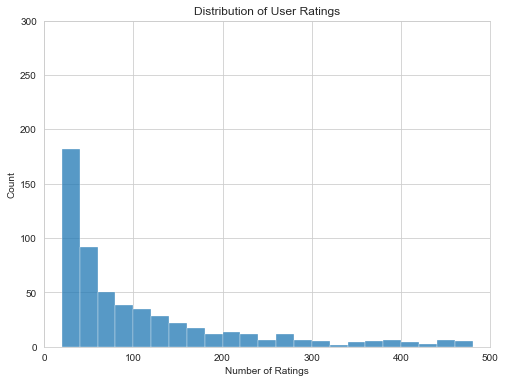

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.histplot(user_counts, binwidth=20, ax=ax)
ax.set(ylim=[0,300], xlim=[0,500], title='Distribution of User Ratings', xlabel='Number of Ratings')

In [16]:
# classify user base on counts of rating
active_levels = ['20-50', '50-80', '80-150', '>150']

user_counts_levels = dict.fromkeys(active_levels, None)
user_counts_levels['20-50'] = user_counts[(user_counts >= 20) & (user_counts < 50)]
user_counts_levels['50-80'] = user_counts[(user_counts >= 50) & (user_counts < 80)]
user_counts_levels['80-150'] = user_counts[(user_counts >= 80) & (user_counts < 150)]
user_counts_levels['>150'] = user_counts[user_counts >= 150]

In [15]:
# calculate rmse for all groups of user
user_level_rmse = []
for key in active_levels:
    indices = user_counts_levels[key].index.tolist()
    pred_df = ratings_df[ratings_df['userId'].isin(indices)]
    print(len(pred_df))
    #y_true = pred_df['rating']
    y_rmse,r_pred = SVDCF(pred_df[['userId','movieId','rating']])
    user_level_rmse.append(y_rmse)

7024
RMSE: 0.9686
6110
RMSE: 0.9233
12108
RMSE: 0.9266
75594
RMSE: 0.8629


[[Text(0, 0, '20-50'),
  Text(1, 0, '50-80'),
  Text(2, 0, '80-150'),
  Text(3, 0, '>150')],
 Text(0.5, 0, 'Number of ratings'),
 Text(0, 0.5, 'rmse')]

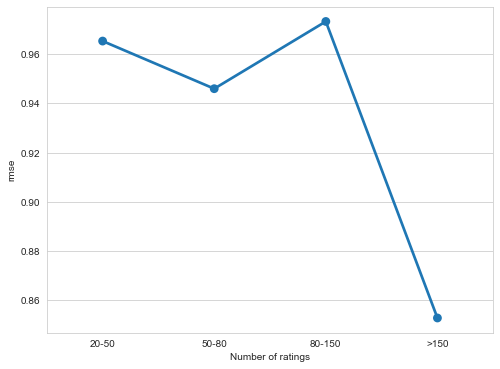

In [209]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')

sns.pointplot(y=user_level_rmse, x=np.arange(4))
ax.set(xticklabels=active_levels, xlabel='Number of ratings', ylabel='rmse')